# 1. Imports

In [9]:
# !pip install adversarial-robustness-toolbox

In [4]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
input_names = ['rho','theta','psi','v_own','v_int']

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -pi, -pi, 100.0,     0.0],
                   [60760.0, pi,  pi, 1200.0, 1200.0] ])

print("> Domaine des inputs :")
inputs_domain = np.zeros((2,5))
inputs_domain[0,0] = (X_dom[0,0]-X_mean[0])/X_range[0]
inputs_domain[1,0] = (X_dom[1,0]-X_mean[0])/X_range[0]
print("- {0} : [{1},{2}]".format(input_names[1],inputs_domain[0,0],inputs_domain[1,0]))
for k in range(1,5):
    inputs_domain[0,k] = -0.5 ; inputs_domain[1,k] = 0.5
    print("- {0} : [{1},{2}]".format(input_names[k],inputs_domain[0,k],inputs_domain[1,k]))

> Domaine des inputs :
- theta : [-0.32842287715105956,0.6798577687061284]
- theta : [-0.5,0.5]
- psi : [-0.5,0.5]
- v_own : [-0.5,0.5]
- v_int : [-0.5,0.5]


# 2. Attack random points and build a confusion matrix

In [6]:
ACAS_labels = ["COC","WR","WL","SR","SL"]

In [7]:
def create_random_pts(npts, boundaries=inputs_domain):
    """ Generate 'npts' random points in the domain defined by the 'boundaries'. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (boundaries[1][f] - boundaries[0][f])
        pts[:,f] += boundaries[0][f]
    return(pts)

In [8]:
def conf_matrix(pred0, pred1, n_classes=5):
    """ Creates the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [9]:
def norm_rows(cmat):
    """ Normalizes the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [10]:
def load_attack(method, acas_model, iter=20, epsilon=0.8, etap=0.95):
    """ Choose your attack with 'method'. """
    
    if method == "nf":
        return(NewtonFool(classifier = acas_model, 
                          eta = etap, 
                          max_iter = iter,
                          verbose = True))
    
    elif method == "fgsm":
        return(FastGradientMethod(estimator = acas_model,
                                  eps = epsilon))
    
    elif method == "cw":
        return(CarliniLInfMethod(classifier = acas_model,
                                 initial_const = 1.0, 
                                 max_iter = iter, 
                                 verbose = True))
    elif method == "Deepfool":
        return DeepFool(classifier=acas_model, max_iter=iter)
    
    else:
        raise Exception("'{0}' is not a valid attack.".format(method))

In [11]:
def build_confusion_matrix(N, method, num_net, folder="/content/", show=True, savefile=None, iter=20,
                                                                                             epsilon=0.001,
                                                                                             etap=0.95):
    """Do not forget to set folder and, if you use Colab, to import your neural networks!"""
    # 1 - Load the model ACAS
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = (-1.0, 1.0))

    attack = load_attack(method, ACAS_classifier, iter = iter,
                                                  epsilon = epsilon,
                                                  etap = etap)

    # 3 - Apply the attack on N random points
    
    base_pts = create_random_pts(N, boundaries=inputs_domain)
    adv_pts = attack.generate(base_pts)
    
    base_pred = model.predict(base_pts)
    base_advice = np.argmin(base_pred, axis=1)
    
    adv_pred = model.predict(adv_pts)
    adv_advice = np.argmin(adv_pred, axis=1)

    # 4 - Confusion matrix
    
    cmat = conf_matrix(base_advice, adv_advice)
    base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    adv_count = (np.bincount(np.concatenate((adv_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    
    # 5 - Show confusion matrix with normalized rows
    
    ncmat = norm_rows(cmat)    
    if show or (savefile!=None):
        index0 = [ACAS_labels[i] + " ({0})".format(base_count[i]) for i in range(5)]
        index1 = ["adv-" + ACAS_labels[i] + " ({0})".format(adv_count[i]) for i in range(5)]
        df_cmat = pd.DataFrame(ncmat, index = index0, columns = index1)

        plt.figure(figsize = (10,7))
        sns.heatmap(df_cmat, annot=True)
        plt.title("Confusion matrix - " + method.upper() + " - #{0}".format(N) + " - network {0}-{1}".format(num_net[0], num_net[1]))
        if show:
            plt.show()
        if savefile:
            plt.savefig(savefile)
    
    return(cmat, ncmat)

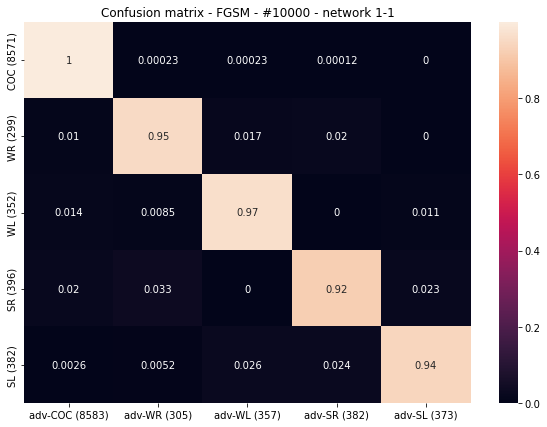

In [27]:
cmat, ncmat = build_confusion_matrix(10000, "fgsm", (1, 1), epsilon=0.001, folder="ACAS_XU_tf_keras/", show=True)

In [ ]:
# Example where we generate several cmat which are automatically saved
for eps in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]:
    filename = "fgsm_cmat/cmat_eps_" + str(eps) + ".png"
    _,_ = build_confusion_matrix(10000, "fgsm", (1, 1), epsilon=eps, folder="ACAS_XU_tf_keras/", savefile=filename, show=False)
    print(eps)

# 3. Plot the evolution of the matrix coefficients when a param changes

In [22]:
def cmat_tracking(N, method, num_net, folder="/content/", param_range=[0.001,0.005,0.01,0.05,0.1,0.5,1.0]):
    """ Plot the evolution of the coefficients of the cmat when we explore param_range. """
    
    # 1 - Load the model ACAS
    
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = inputs_domain)
    
    # 3 - Generate N random points and create the 3D matrix to store the cmat
    
    base_pts = create_random_pts(N, boundaries=inputs_domain)
    base_pred = model.predict(base_pts)
    base_advice = np.argmin(base_pred, axis=1)
    base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)

    ncmat = len(param_range)
    confusion_cube = np.zeros((ncmat+1,5,5))
    confusion_cube[0] = N*np.eye(5) # base points without any attack

    # 4 - Iter over the param_range and attack the base_pts
    
    for k in range(len(param_range)):
        pk = param_range[k]
        attack = load_attack(method, ACAS_classifier, iter = None, epsilon = pk, etap = None)
        
        adv_pts = attack.generate(base_pts)
        adv_pred = model.predict(adv_pts)
        adv_advice = np.argmin(adv_pred, axis=1)
        
        confusion_cube[k+1] = conf_matrix(base_advice, adv_advice) # store the confusion matrix in the confusion cube
        # adv_count = (np.bincount(np.concatenate((adv_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
        # print(pk)

    return(confusion_cube)

In [ ]:
eps_range = [0.002*k for k in range(1,500)]
conf_cube = cmat_tracking(1000, "fgsm", (1, 1), folder="ACAS_XU_tf_keras/", param_range=eps_range)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.01
0.011
0.012
0.013000000000000001
0.014
0.015
0.016
0.017
0.018000000000000002
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026000000000000002
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.088
0.089
0.09
0.091
0.092


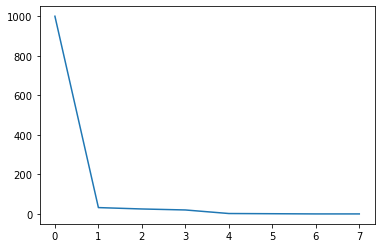

In [24]:
plt.plot(np.arange(conf_cube.shape[0]), conf_cube[:,1,1])

In [21]:
conf_cube[:,1,1]

array([ 1., 29., 25., 18.,  4.,  3.,  1.,  1.])